In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import pybamm as pb;import pandas as pd   ;import numpy as np;
import os;
import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import timeit
import random;import time, signal
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
print(515*12)

6180


In [3]:
## Global setting: change with PC or HPC
# Path_NiallDMA = "InputData/" # for HPC
Path_NiallDMA = "D:/OneDrive - Imperial College London/SimDataSave/InputData/"
# BasicPath=os.getcwd() # for HPC
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P2_R9_Dim/Test' 
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import * # directly do this for HPC

# Set Experiment 
index_exp = 5 # index for experiment set, can now go for 2,3,5
Round_No = 1  # index to identify different rounds of running 

#########  Actively sweep parameters  ##############
Para_active = {
   "Ageing temperature":[10, ], # 25, 40 
   "Total ageing cycles":[1170,], # 6192
   "Ageing cycles between RPT":[78,], # 516
   "Update cycles for ageing": [78,],
   "Initial electrolyte excessive amount ratio":[ 1.01], # set to <1 for DryOut=Off
   # rate of dry-out:
   "Outer SEI partial molar volume [m3.mol-1]":[9.585e-05] ,
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[3e-20,],    
   # LiP and coupling with SEI:
   "Dead lithium decay constant [s-1]":[ 1e-6,],            # default: 1e-6
   'Lithium plating kinetic rate constant [m.s-1]':[1E-10], # default: 1e-9
   # Crack model
   "Negative electrode LAM constant proportional term [s-1]":[ 5e-9,5e-8], # default: 2.7778e-07
   "Positive electrode LAM constant proportional term [s-1]":[ 5e-7,], # default: 2.7778e-07
   "Negative electrode cracking rate":[ 1e-20,],   # default: function, ~3.9e-20 
}

In [4]:
# Inactively sweep parameters
Para_dict_Same = {
   #"Positive electrode cracking rate":[ 1e-22,],   # default: function, ~3.9e-20 
   "Cycles within RPT":[1,],
   "RPT temperature":[25,],
   "Mesh list":[[5,5,5,60,20],],   # Simon uses 30
   "Para_Set":[ "OKane2023",], # Li2023_Coupled
   "Model option":[
      {
         "contact resistance": "true",
         "open-circuit potential": "current sigmoid",
         "thermal": "lumped",
         "SEI": "interstitial-diffusion limited",
         "SEI on cracks": "true",
         "SEI film resistance": "distributed", 
         "SEI porosity change": "true",
         "particle mechanics": ("swelling and cracking", "swelling only"),
         "loss of active material": "stress-driven",
         "lithium plating": "partially reversible",
      },
      ],
   "Contact resistance [Ohm]": [0.0105,],   
   "Current solvent concentration in the reservoir [mol.m-3]":[4541.0,],
   "Current electrolyte concentration in the reservoir [mol.m-3]":[1000,],
   "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":[1.0,],
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
   'Typical EC concentration in electrolyte [mol.m-3]':[4541.0,], # Mark Ruihe change, act as an initial value here
   
   #"Negative electrode volume change":[ 0.0,],
   #"Positive electrode volume change":[ 0.0,],
   #"Initial Neg SOC":[0.850],    #list(np.linspace(0.84,0.90,6)),
   #"Initial Pos SOC":[0.2705], # list(np.linspace(0.22,0.27,6)),
}
Para_dict_All = {**Para_dict_Same,**Para_active}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 2


In [5]:
# set up experiment
Target  = f'/Exp{index_exp}_Round_{Round_No}/'
book_name_xlsx = f'Exp{index_exp}_Round_{Round_No}.xlsx';
V_max = 4.2;        V_min = 2.5; 
if index_exp ==2:
    discharge_time_mins = 0.15* 60 * 4.86491/5
    charge_time_mins = 0.5* 60 * 4.86491/5
    exp_AGE_text = [(
        f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
        f"Charge at 0.3C for {charge_time_mins} minutes or until {V_max}V",
        ),  ]  # *  setting on cycler is 516, rather than 514 in wiki
elif index_exp ==3:
    discharge_time_mins = 0.15* 60 * 4.86491/5
    charge_time_mins = 0.5* 60 * 4.86491/5
    exp_AGE_text = [(
        f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
        f"Charge at 0.3C until {V_max}V",
        f"Hold at {V_max} V until C/100",
        ),  ]   # *  setting on cycler is 515, rather than 514 in wiki
elif index_exp ==5:
    exp_AGE_text = [(
        f"Discharge at 1C until {V_min}V", 
        f"Charge at 0.3C until {V_max}V",
        f"Hold at {V_max} V until C/100",
        ),  ]  # *  78 *15 = 1170
else:
    print("Not yet implemented!")
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

In [6]:
# remaining set-up for experiment and create folders
sheet_name_xlsx = 'Results';
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
if not os.path.exists(BasicPath + Target+"Mats"):
   os.mkdir(BasicPath + Target+"Mats");
if not os.path.exists(BasicPath + Target+"Plots"):
   os.mkdir(BasicPath + Target+"Plots");
if not os.path.exists(BasicPath + Target+"Excel"):
   os.mkdir(BasicPath + Target+"Excel");

Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,]

exp_RPT_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V (30 minute period)",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V (30 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)",
    # 0.5C cycle 
    f"Discharge at 0.5C until {V_min} V (6 minute period)",  
    "Rest for 3 hours (20 minute period)",
    f"Charge at 0.5C until {V_max} V (6 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 3 hours (20 minute period)",  
    ) ] * 1
# step index for RPT
step_0p1C_CD = 2; step_0p1C_CC = 4;   step_0p1C_RE =3;    
step_0p5C_CD = 7;  

exp_text_list = [exp_AGE_text,  exp_RPT_text ];
cycle_no = -1; 
exp_index_pack = [cycle_no,step_AGE_CD,step_AGE_CC,step_AGE_CV,
   step_0p1C_CD, step_0p1C_CC,step_0p1C_RE , step_0p5C_CD ];


In [7]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]


In [8]:
# Load Niall's data
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp-1] 
Exp_Any_AllData = Read_Exp(
    Path_NiallDMA,Exp_All_Cell[index_exp-1],
    Exp_Path,Exp_head,Exp_Temp_Cell[index_exp-1],
    index_exp-1)


Finish reading Experiment!


In [9]:
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    "CDend X-averaged total SEI on cracks thickness [m]",
    "CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


In [10]:
# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %","Dry out"]

head_pos = [ "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
index_list = np.arange(1,len(Para_dict_list)+1,1)
for Scan_i,Para_dict_i in zip(index_list,Para_dict_list):
    value_list_temp = list(Para_dict_i.values())
    values_para = []
    for value_list_temp_i in value_list_temp:
        values_para.append(str(value_list_temp_i))
    # sequence: scan no, exp, pass or fail, mpe, dry-out, 
    mpe_all = ["Unknown","Unknown",
        "Unknown","Unknown", 
        "Unknown","Unknown",]
    Pass_Fail = "Unknown"
    DryOut = "Unknown"
    value_Pre = [str(Scan_i),index_exp,Pass_Fail,*mpe_all,DryOut,]
    values = [*value_Pre,*values_para,]
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, Values_1)   


Successfully create a excel file


Start Now! Scan 1.
Scan 1: DryOut = On
Initial electrolyte amount is  5.093480124590676 mL
Scan 1: Spent 149.587 ms on Initialization


At t = 1312.33 and h = 1.22152e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish break-in cycle within 1 minute, 19 seconds
Scan 1: Finish post-process for break-in cycle within 178.290 ms


At t = 101.95 and h = 5.6903e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.95 and h = 1.14474e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.95 and h = 6.15599e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.0 ageing cycles within 42 minutes, 3 seconds
Scan 1: Finish post-process for No.78 ageing cycles within 338.202 ms


At t = 1080.81 and h = 2.14189e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 356.389 and h = 1.33943e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.78 RPT cycles within 1 minute, 18 seconds
Scan 1: Finish post-process for No.78 RPT cycles within 108.820 ms


At t = 88.7271 and h = 4.69174e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 88.7269 and h = 1.13736e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 88.7265 and h = 5.51794e-16, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.78 ageing cycles within 42 minutes, 13 seconds
Scan 1: Finish post-process for No.156 ageing cycles within 133.653 ms


At t = 832.74 and h = 1.23704e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 832.742 and h = 1.05302e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 307.579 and h = 1.07133e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.156 RPT cycles within 1 minute, 22 seconds
Scan 1: Finish post-process for No.156 RPT cycles within 119.887 ms


At t = 62.9075 and h = 7.31558e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 62.9075 and h = 6.01543e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 62.9072 and h = 1.92287e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 539.963 and h = 5.2248e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.9625 and h = 5.29252e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.9624 and h = 8.88597e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.9625 and h = 7.63826e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 539.797 and h = 5.21039e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.7968 and h = 5.40802e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.7977 and h = 4.0853e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 1: Finish for No.156 ageing cycles within 55 minutes, 26 seconds
Scan 1: Finish post-process for No.234 ageing cycles within 129.109 ms


At t = 225.795 and h = 7.47587e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 225.798 and h = 1.75e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.234 RPT cycles within 1 minute, 23 seconds
Scan 1: Finish post-process for No.234 RPT cycles within 113.750 ms


At t = 501.804 and h = 3.65239e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 501.621 and h = 1.85029e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 501.439 and h = 2.83413e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 501.257 and h = 3.94559e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 501.074 and h = 8.88088e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 500.891 and h = 9.30362e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 500.705 and h = 2.97476e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 500.523 and h = 1.01098e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 500.339 and h = 7.13576e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 500.154 and h = 7.97993e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.234 ageing cycles within 48 minutes, 34 seconds
Scan 1: Finish post-process for No.312 ageing cycles within 121.803 ms


At t = 1693.32 and h = 7.5512e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 784.316 and h = 9.35558e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 122.864 and h = 2.14815e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 122.864 and h = 1.68453e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 122.863 and h = 1.00631e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.312 RPT cycles within 1 minute, 29 seconds
Scan 1: Finish post-process for No.312 RPT cycles within 112.677 ms


At t = 512.283 and h = 9.27751e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 451.129 and h = 1.77147e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 211.127 and h = 2.0882e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 91.1288 and h = 6.20178e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 450.907 and h = 2.10906e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 210.907 and h = 5.59536e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.9066 and h = 2.7494e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 450.682 and h = 2.9997e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 210.685 and h = 5.3746e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.6847 and h = 6.46286e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t

Scan 1: Finish for No.312 ageing cycles within 57 minutes, 33 seconds
Scan 1: Finish post-process for No.390 ageing cycles within 121.581 ms


At t = 943.41 and h = 5.06754e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 335.298 and h = 1.28692e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.390 RPT cycles within 1 minute, 28 seconds
Scan 1: Finish post-process for No.390 RPT cycles within 130.739 ms


At t = 439.631 and h = 3.70242e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.631 and h = 6.0466e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 79.6308 and h = 1.50807e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 378.272 and h = 1.81522e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.271 and h = 7.3249e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 377.965 and h = 3.18206e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 137.965 and h = 4.10539e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 377.658 and h = 2.19713e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 137.658 and h = 5.19541e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 377.348 and h = 8.47036e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 1: Finish for No.390 ageing cycles within 56 minutes, 13 seconds
Scan 1: Finish post-process for No.468 ageing cycles within 116.998 ms


At t = 1478.41 and h = 8.82417e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 569.406 and h = 1.29457e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.4326 and h = 5.01157e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.4346 and h = 1.62868e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.435 and h = 4.38634e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.468 RPT cycles within 1 minute, 35 seconds
Scan 1: Finish post-process for No.468 RPT cycles within 131.967 ms


At t = 317.393 and h = 1.82714e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.3927 and h = 1.41803e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.3925 and h = 7.00964e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 255.576 and h = 4.17033e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 255.078 and h = 1.04494e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 254.578 and h = 3.70089e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 254.073 and h = 3.08828e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 253.563 and h = 9.44868e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 253.049 and h = 9.4438e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 252.529 and h = 5.39093e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 1: Finish for No.468 ageing cycles within 51 minutes, 49 seconds
Scan 1: Finish post-process for No.546 ageing cycles within 102.367 ms


At t = 397.949 and h = 5.15249e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 397.948 and h = 5.07801e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 397.95 and h = 4.46492e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.897 and h = 7.73014e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.895 and h = 3.4952e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.8946 and h = 1.77335e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.546 RPT cycles within 1 minute, 29 seconds
Scan 1: Finish post-process for No.546 RPT cycles within 99.103 ms


At t = 49.0727 and h = 5.43062e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 49.074 and h = 9.40703e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 49.074 and h = 8.58219e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 49.0741 and h = 1.26491e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 526.201 and h = 3.48058e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 46.2 and h = 1.1188e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 46.2015 and h = 4.1796e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 46.2014 and h = 6.20221e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 525.47 and h = 1.63321e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 45.4707 and h = 3.26003e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 4

Fail due to Experiment error or infeasible
Scan 1: Fail during No.546 ageing cycles within 4 minutes, 35 seconds due to Experiment error or infeasible


At t = 1758.69 and h = 2.60244e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 849.684 and h = 9.79091e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 395.184 and h = 1.03592e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 144.217 and h = 1.40997e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 144.217 and h = 8.47614e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 144.217 and h = 1.33524e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.546 RPT cycles within 1 minute, 35 seconds
Scan 1: Finish post-process for No.546 RPT cycles within 99.269 ms
Scan 1: Getting extra variables within 63.800 us
Scan 1: Finish all plots within 5.157 s
Successfully create a excel file
Scan 1: Finish saving mat and xlsx within 22.212 ms
Succeed doing something in 6 hours, 11 minutes, 33 seconds
This is the end of No. 1  scan
Start Now! Scan 2.
Scan 2: DryOut = On
Initial electrolyte amount is  5.093480124590676 mL
Scan 2: Spent 2.870 ms on Initialization


At t = 1302.83 and h = 4.88078e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish break-in cycle within 1 minute, 14 seconds
Scan 2: Finish post-process for break-in cycle within 155.441 ms


At t = 99.6974 and h = 1.18618e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 99.6995 and h = 1.26338e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 99.6996 and h = 9.75596e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 539.377 and h = 1.37496e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.3773 and h = 2.48063e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.3774, repeated recoverable residual errors.
At t = 59.376 and h = 3.72479e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 538.478 and h = 1.5358e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 58.4778 and h = 2.31929e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 58.4778 and h = 1.8738e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 58.4778 and h = 1.53636e-12, the corrector

Scan 2: Finish for No.0 ageing cycles within 46 minutes, 51 seconds
Scan 2: Finish post-process for No.78 ageing cycles within 312.505 ms


At t = 456.726 and h = 2.55049e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 456.724 and h = 8.9394e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 233.141 and h = 6.0252e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 233.143 and h = 5.26172e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 83.1435 and h = 5.76689e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.78 RPT cycles within 1 minute, 29 seconds
Scan 2: Finish post-process for No.78 RPT cycles within 110.878 ms


At t = 505.688 and h = 1.13764e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 504.781 and h = 3.71467e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.874 and h = 4.5263e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 502.968 and h = 1.70391e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 502.06 and h = 1.26359e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 501.152 and h = 2.8733e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 500.245 and h = 2.58727e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 499.336 and h = 2.63526e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 498.428 and h = 2.18687e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 497.519 and h = 9.61101e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 2: Finish for No.78 ageing cycles within 55 minutes, 35 seconds
Scan 2: Finish post-process for No.156 ageing cycles within 112.949 ms


At t = 1462.89 and h = 3.16897e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 553.85 and h = 3.4269e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.7557 and h = 5.46466e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.7559 and h = 2.93659e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.7558 and h = 4.10765e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.156 RPT cycles within 1 minute, 27 seconds
Scan 2: Finish post-process for No.156 RPT cycles within 101.967 ms


At t = 489.271 and h = 1.70785e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 427.429 and h = 1.31825e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 187.429 and h = 3.38909e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.429 and h = 4.60981e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 426.493 and h = 4.40287e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 186.493 and h = 2.90441e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.4928 and h = 2.04369e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 425.557 and h = 1.89754e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.558 and h = 4.91753e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 65.5578 and h = 1.97136e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 2: Finish for No.156 ageing cycles within 57 minutes, 8 seconds
Scan 2: Finish post-process for No.234 ageing cycles within 108.809 ms


At t = 455.064 and h = 2.82454e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 455.064 and h = 3.05169e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 240.333 and h = 1.60202e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 240.333 and h = 8.374e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.3332 and h = 5.90458e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.234 RPT cycles within 1 minute, 31 seconds
Scan 2: Finish post-process for No.234 RPT cycles within 102.328 ms


At t = 392.287 and h = 1.87385e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 152.287 and h = 2.96311e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 330.299 and h = 5.75547e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.299 and h = 1.06754e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.2982 and h = 2.63926e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 329.318 and h = 1.68598e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.318 and h = 2.9132e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.318 and h = 9.22396e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 328.338 and h = 4.80963e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 88.3361 and h = 1.098e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t =

Scan 2: Finish for No.234 ageing cycles within 56 minutes, 45 seconds
Scan 2: Finish post-process for No.312 ageing cycles within 106.442 ms


At t = 1131.8 and h = 2.14847e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.312 RPT cycles within 1 minute, 22 seconds
Scan 2: Finish post-process for No.312 RPT cycles within 106.873 ms


At t = 283.939 and h = 2.64145e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 43.9392 and h = 1.47612e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 43.9384 and h = 3.4676e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 43.9392 and h = 1.29462e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 221.774 and h = 3.59488e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 221.774 and h = 4.39191e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.774 and h = 7.89256e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 41.7739 and h = 4.38411e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 220.716 and h = 2.06654e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 220.716 and h = 1.66229e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 2: Finish for No.312 ageing cycles within 1 hour, 0 minutes, 50 seconds
Scan 2: Finish post-process for No.390 ageing cycles within 115.793 ms


At t = 1569.4 and h = 4.78526e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 660.451 and h = 7.57197e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.946 and h = 2.64404e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.946 and h = 4.80548e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.942 and h = 1.32205e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.390 RPT cycles within 1 minute, 28 seconds
Scan 2: Finish post-process for No.390 RPT cycles within 98.576 ms


At t = 152.142 and h = 2.08473e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 152.141 and h = 7.50746e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.7536 and h = 1.91138e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.7535 and h = 4.13959e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.7536 and h = 1.37654e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 88.5721 and h = 2.97528e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 88.5721 and h = 1.95334e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 88.5721 and h = 1.63613e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 87.3888 and h = 3.11633e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 87.3888 and h = 3.78712e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.390 ageing cycles within 55 minutes, 37 seconds
Scan 2: Finish post-process for No.468 ageing cycles within 96.775 ms


At t = 1437.12 and h = 3.1518e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 528.119 and h = 6.89748e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.792 and h = 7.96487e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.7906 and h = 1.64852e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.7883 and h = 1.58082e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.468 RPT cycles within 1 minute, 30 seconds
Scan 2: Finish post-process for No.468 RPT cycles within 96.596 ms


At t = 505.049 and h = 1.21764e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 442.095 and h = 3.91211e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 202.096 and h = 1.62279e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.0957 and h = 7.71359e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 440.621 and h = 1.92484e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 200.621 and h = 4.37862e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 80.6214 and h = 5.92568e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 439.142 and h = 2.21533e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 199.142 and h = 4.17705e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 79.1418 and h = 5.43211e-13, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.468 ageing cycles within 1 hour, 2 minutes, 42 seconds
Scan 2: Finish post-process for No.546 ageing cycles within 86.872 ms


At t = 1177.13 and h = 3.99301e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 268.135 and h = 4.87343e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 268.134 and h = 6.85233e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.4004 and h = 5.64968e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.4005 and h = 7.82059e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.4005 and h = 3.43201e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.4005 and h = 4.16597e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.546 RPT cycles within 1 minute, 52 seconds
Scan 2: Finish post-process for No.546 RPT cycles within 97.817 ms


At t = 151.602 and h = 3.72584e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 151.602 and h = 1.13534e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 121.304 and h = 2.28496e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 121.297 and h = 1.78949e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 119.252 and h = 1.34265e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 119.252 and h = 9.39847e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 119.272 and h = 2.04173e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.2683 and h = 2.3875e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.272 and h = 1.48295e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.2514 and h = 6.45508e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At

Fail due to Experiment error or infeasible
Scan 2: Fail during No.546 ageing cycles within 21 minutes, 23 seconds due to Experiment error or infeasible


At t = 713.233 and h = 2.58749e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 713.233 and h = 2.0816e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 258.732 and h = 3.46711e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 322.99 and h = 4.01552e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.546 RPT cycles within 1 minute, 42 seconds
Scan 2: Finish post-process for No.546 RPT cycles within 93.130 ms
Scan 2: Getting extra variables within 63.000 us
Scan 2: Finish all plots within 10.970 s
Successfully create a excel file
Scan 2: Finish saving mat and xlsx within 22.136 ms
Succeed doing something in 7 hours, 10 minutes, 39 seconds
This is the end of No. 2  scan


' if __name__ == "__main__":\n    pool = multiprocessing.Pool(2)\n    processes = [\n    pool.apply_async(\n        Run_P2_Opt_Timeout, \n        args=(\n            index_i    ,  index_exp,  Para_dict_i,   Path_pack, fs,\n            keys_all,   exp_text_list, exp_index_pack,\n            Exp_Any_AllData,Temp_Cell_Exp, dpi,\n            True,False,True,True\n        ) )\n        for index_i, Para_dict_i in zip(index_list,Para_dict_list)]\n    Result = [p.get() for p in processes]  \nfor result in Result:\n    midc_merge_all.append(result[0])\n    Sol_RPT_all.append(result[1])\n    Sol_AGE_all.append(result[2]) \n\n '

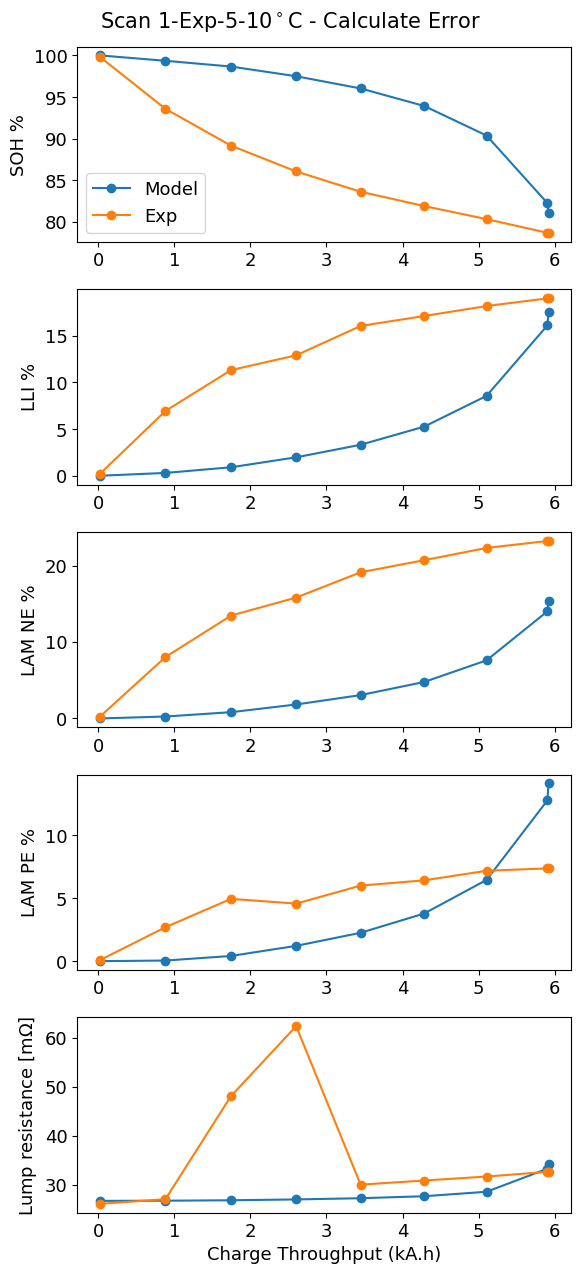

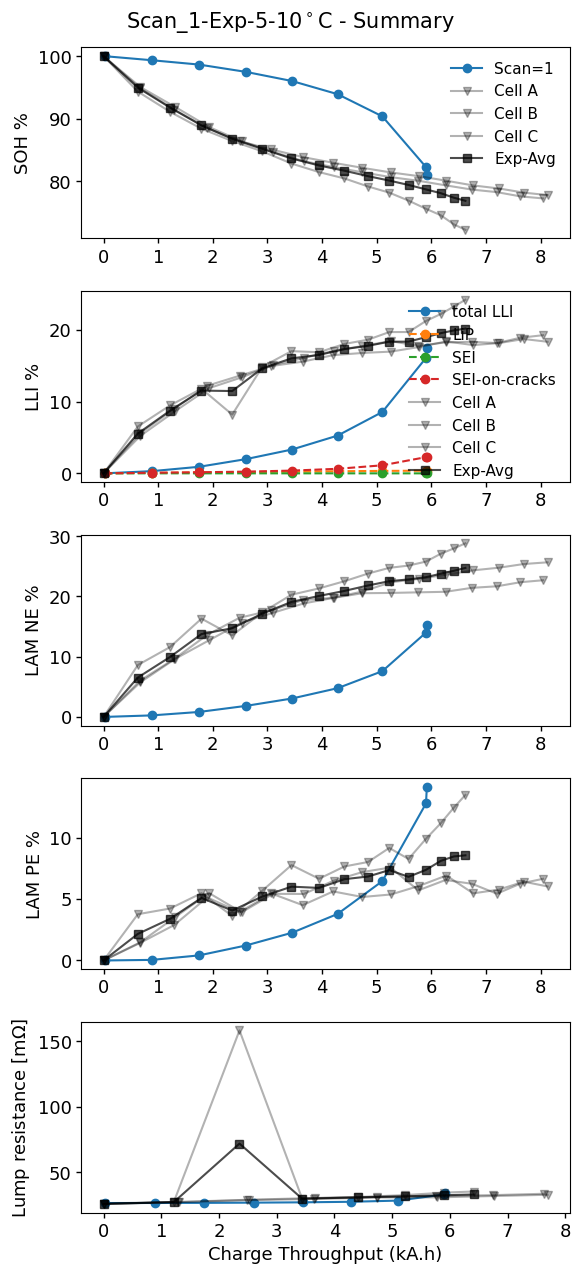

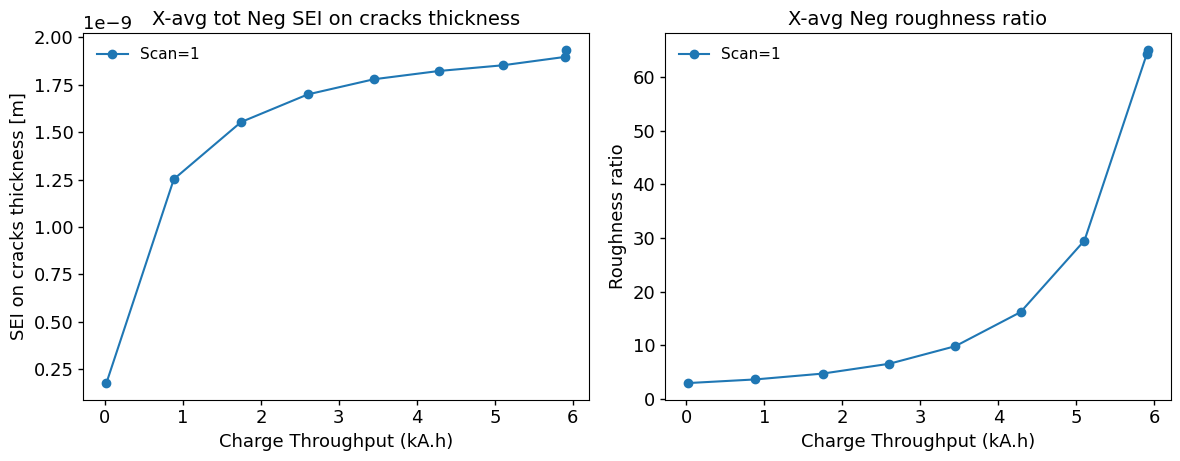

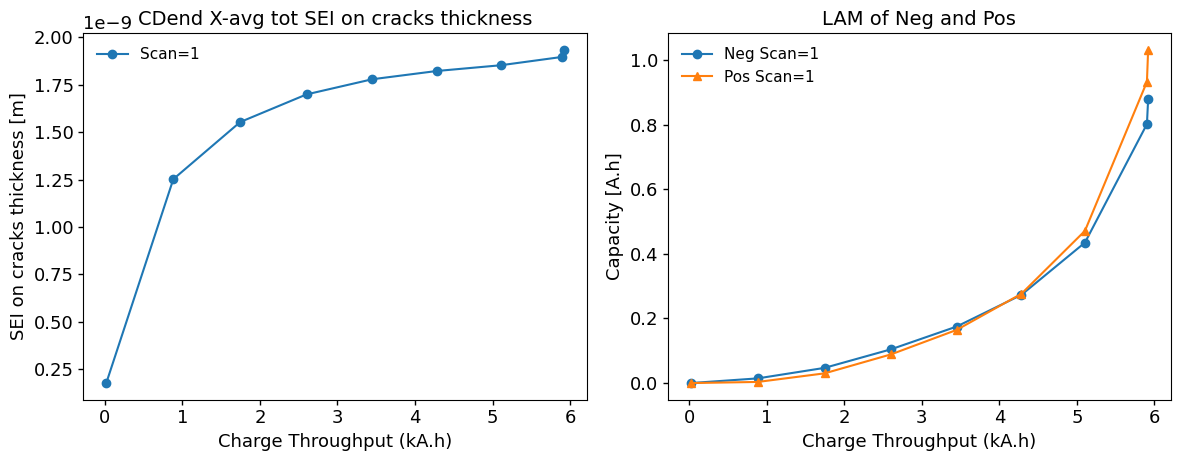

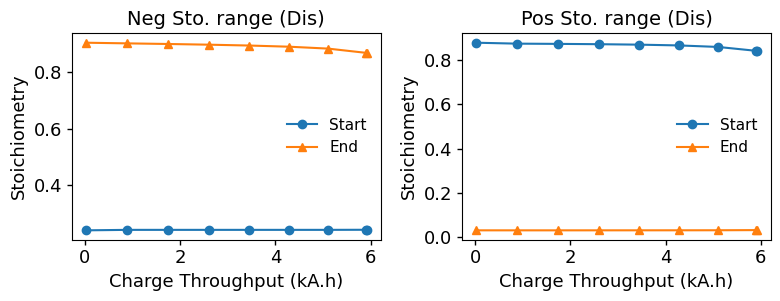

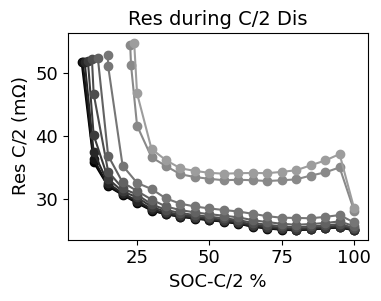

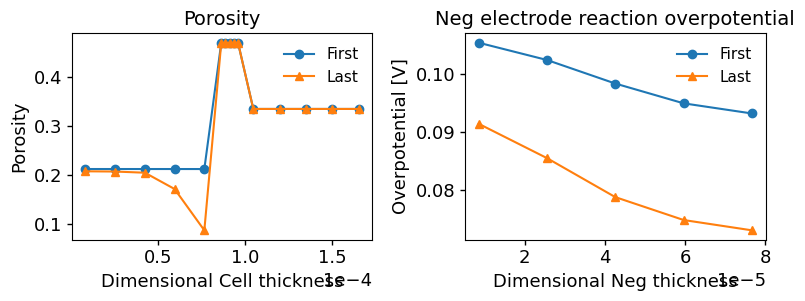

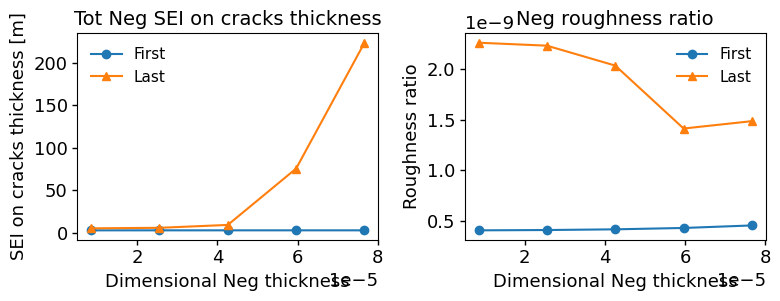

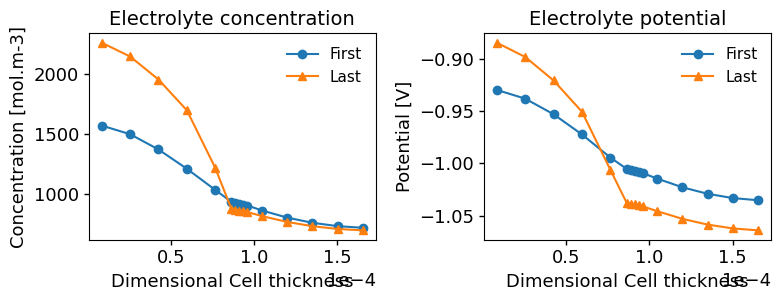

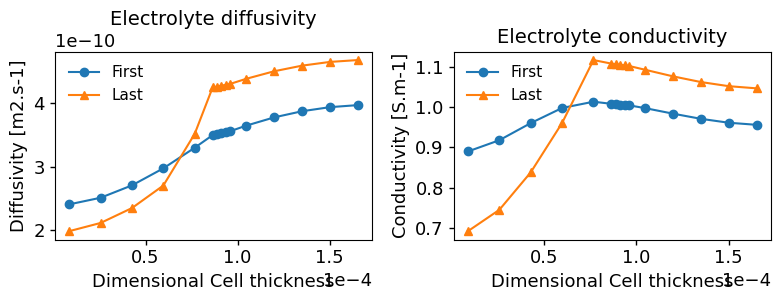

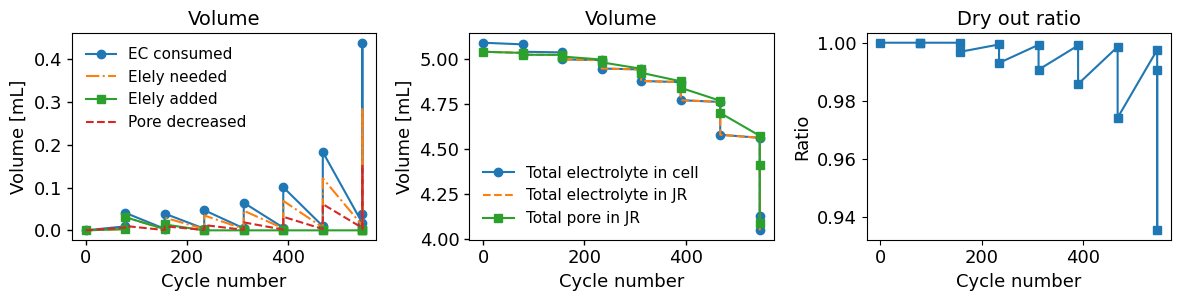

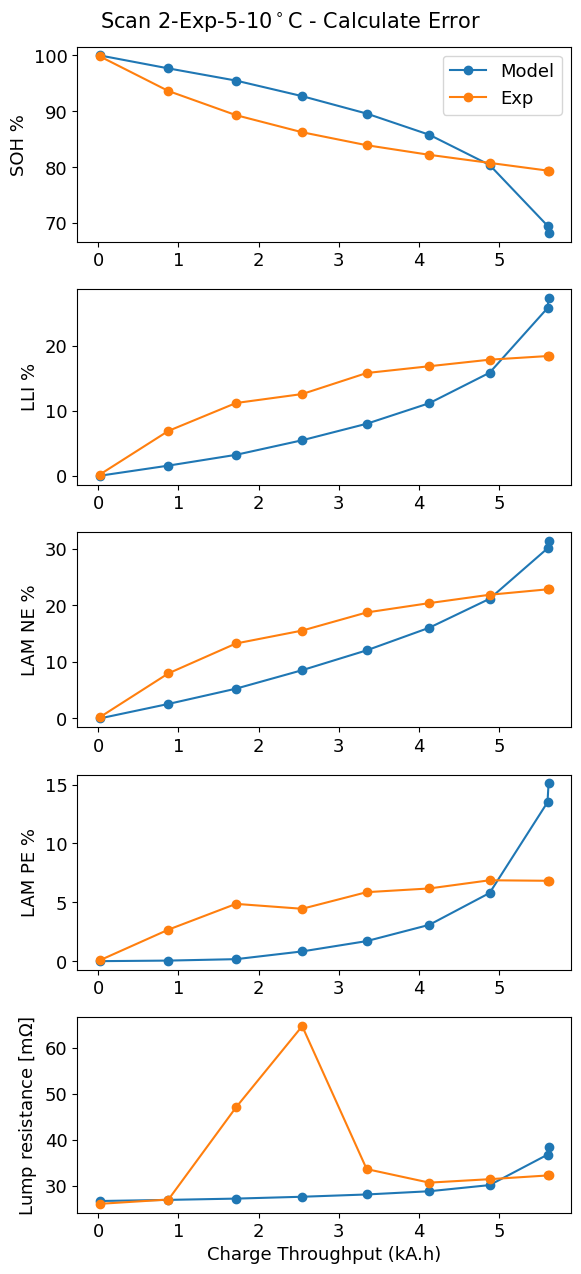

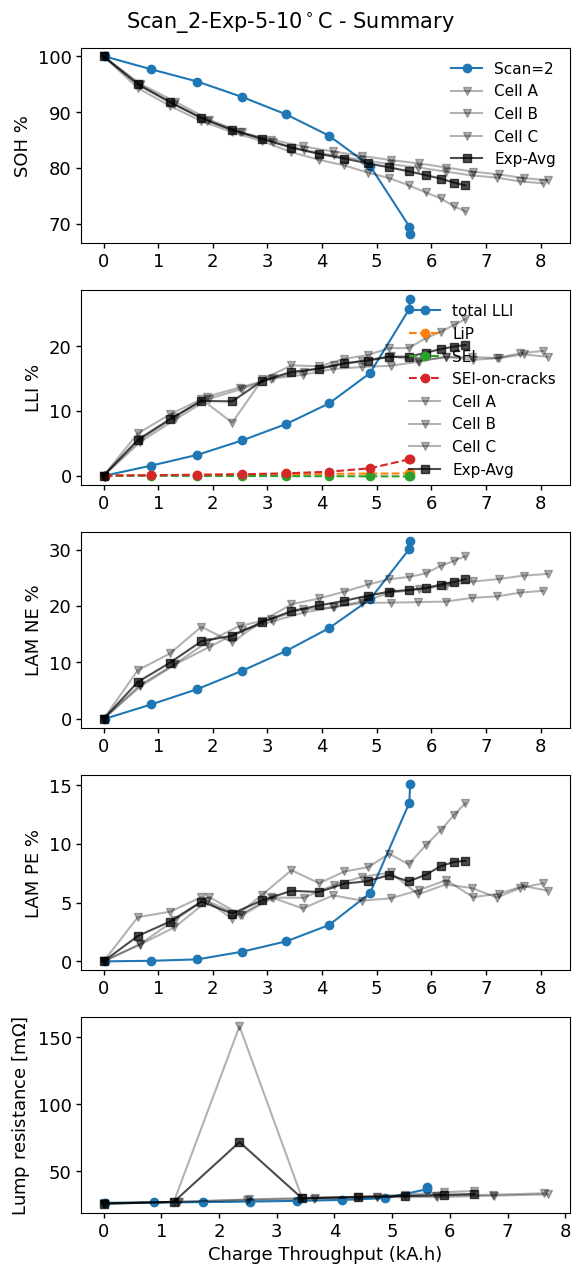

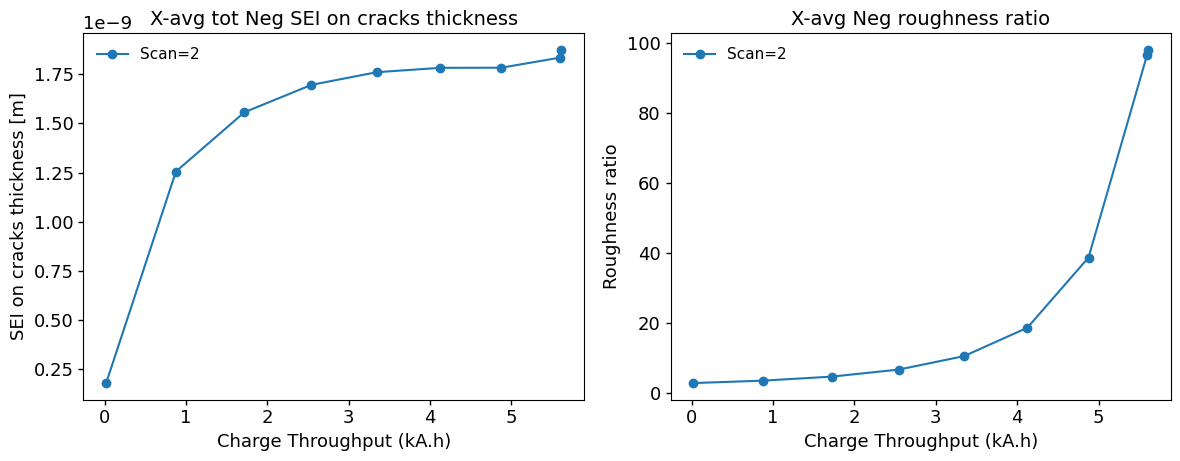

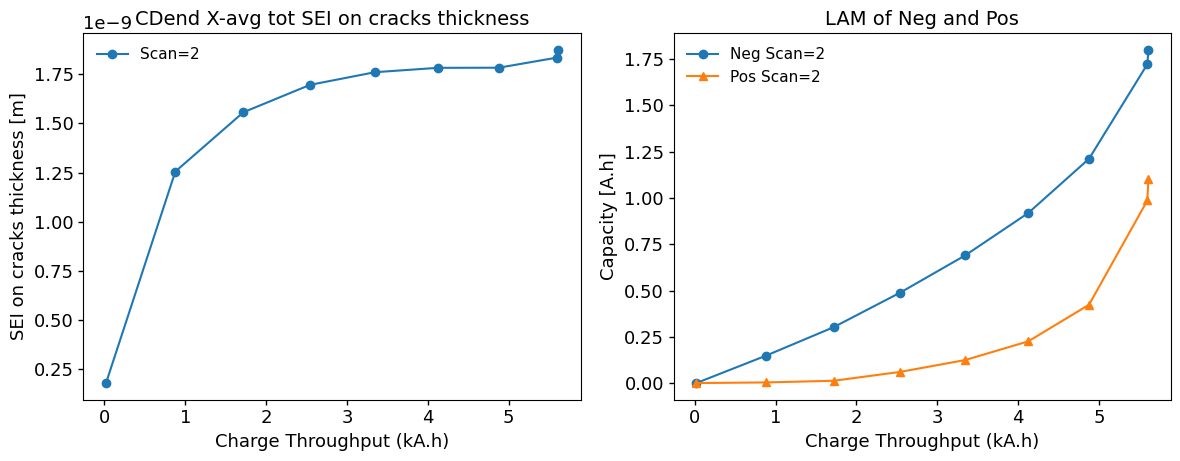

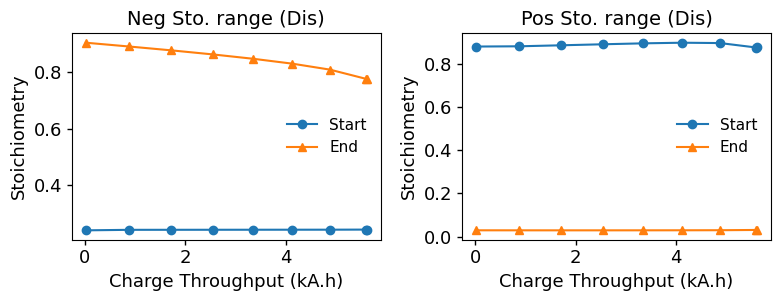

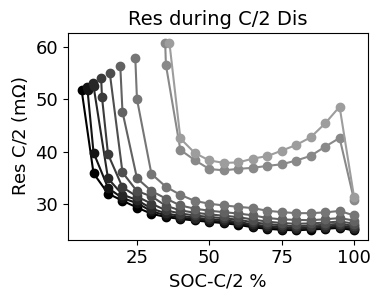

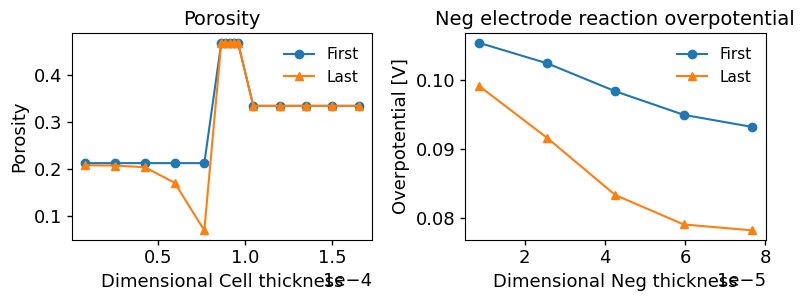

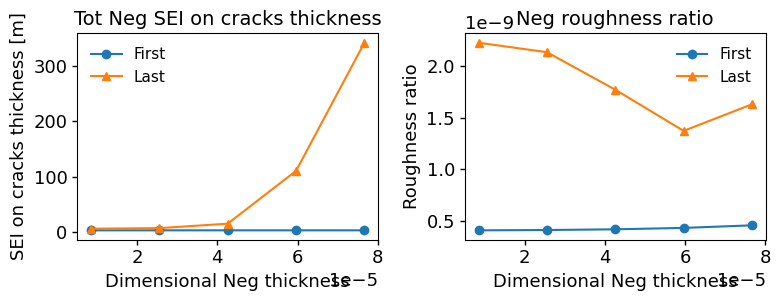

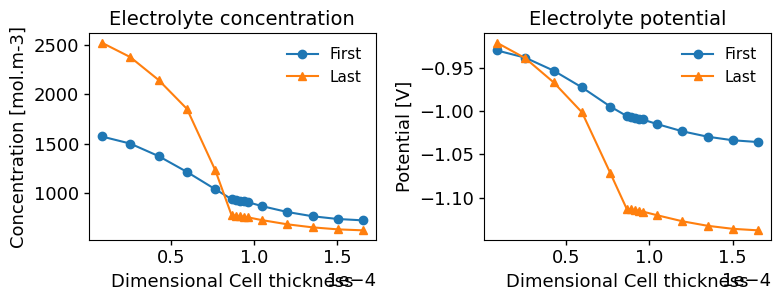

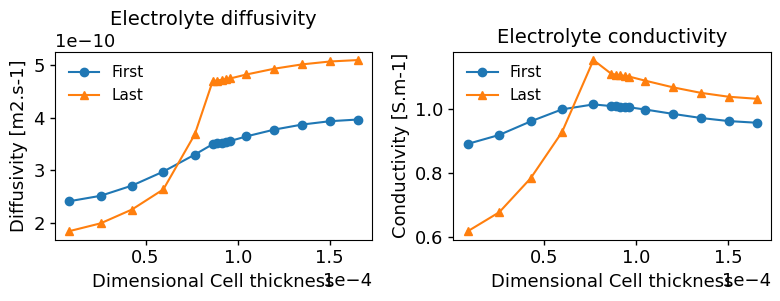

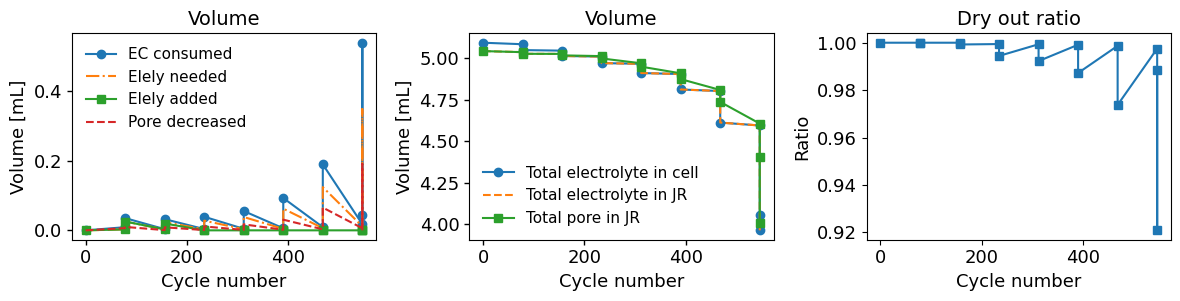

In [11]:
# scan:
fs = 13; dpi = 100;
index_list = np.arange(1,len(Para_dict_list)+1,1)
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
for index_i, Para_dict_i in zip(index_list,Para_dict_list):
    midc_merge,Sol_RPT,Sol_AGE = Run_P2_Opt_Timeout(
        index_i    ,  index_exp,  Para_dict_i,   Path_pack, fs,
        keys_all,   exp_text_list, exp_index_pack,
        Exp_Any_AllData,Temp_Cell_Exp, dpi,
        Plot_Exp=True,Timeout=False,Return_Sol=True,Check_Small_Time=True,)  
    midc_merge_all.append(midc_merge)
    Sol_RPT_all.append(Sol_RPT)
    Sol_AGE_all.append(Sol_AGE) 

""" for index_i, Para_dict_i in zip(index_list,Para_dict_list):
    midc_merge,Sol_RPT,Sol_AGE = Run_P2_Opt_Timeout(
        index_i    ,    Para_dict_i,   Path_pack, fs,
        keys_all,   exp_text_list, exp_index_pack,
        Exp_Any_AllData,Temp_Cell_Exp,
        True,True,False,)    #Plot_Exp,  Timeout, Return_Sol  
"""
""" if __name__ == "__main__":
    pool = multiprocessing.Pool(2)
    processes = [
    pool.apply_async(
        Run_P2_Opt_Timeout, 
        args=(
            index_i    ,  index_exp,  Para_dict_i,   Path_pack, fs,
            keys_all,   exp_text_list, exp_index_pack,
            Exp_Any_AllData,Temp_Cell_Exp, dpi,
            True,False,True,True
        ) )
        for index_i, Para_dict_i in zip(index_list,Para_dict_list)]
    Result = [p.get() for p in processes]  
for result in Result:
    midc_merge_all.append(result[0])
    Sol_RPT_all.append(result[1])
    Sol_AGE_all.append(result[2]) 

 """

i_try = 0
while i_try<3:
    try:
        getSth = Sol_0["Throughput capacity [A.h]"].entries[-1]
    except:
        i_try += 1
        print(f"Fail to read Throughput capacity for the {i_try}th time")
    else:
        break
print(getSth)

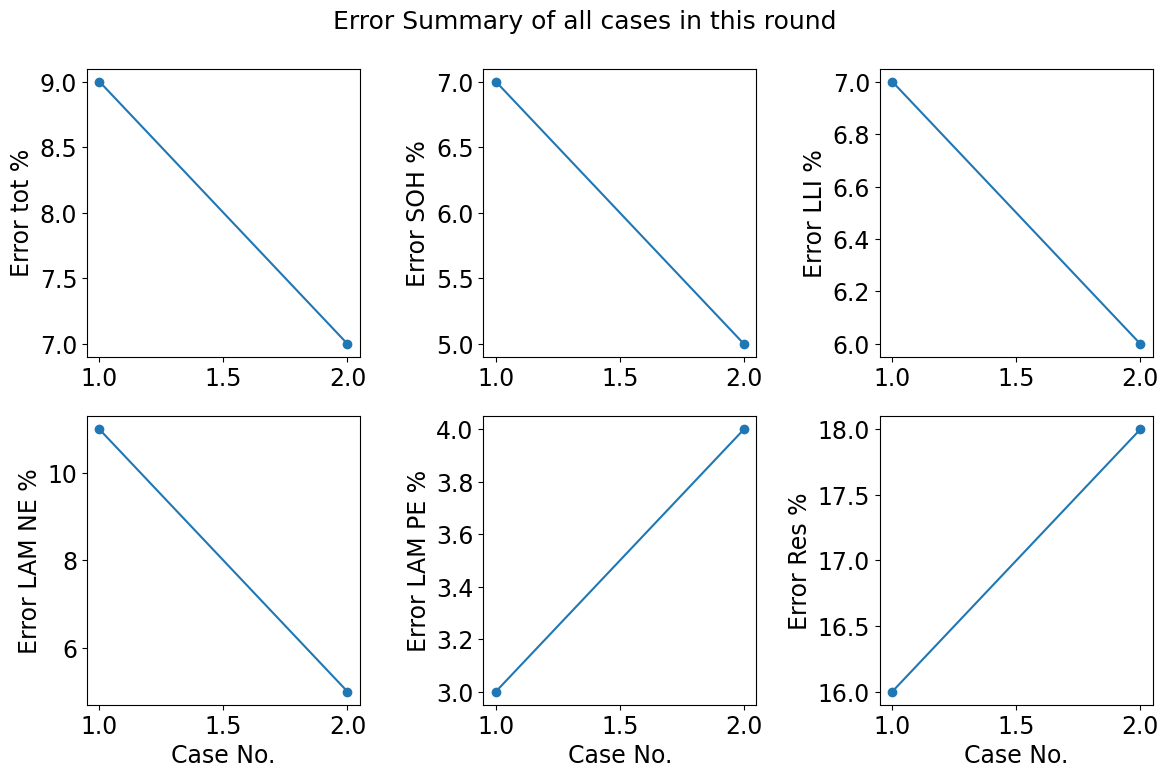

In [12]:
# After finish scans, get summary of the errors of all cases:
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Caes_Index = np.arange(1,len(midc_merge_all)+1)
Mpe_tot = []; Mpe_1 = [];Mpe_2 = []; Mpe_3 = [];Mpe_4 = []; Mpe_5 = [];
for i in range(len(midc_merge_all)):
    Mpe_tot.append(midc_merge_all[i]["Error tot %"])
    Mpe_1.append(midc_merge_all[i]["Error SOH %"])
    Mpe_2.append(midc_merge_all[i]["Error LLI %"])
    Mpe_3.append(midc_merge_all[i]["Error LAM NE %"])
    Mpe_4.append(midc_merge_all[i]["Error LAM PE %"])
    Mpe_5.append(midc_merge_all[i]["Error Res %"])
Mpe_All = [Mpe_tot,Mpe_1,Mpe_2,Mpe_3,Mpe_4,Mpe_5]
Str_All = [
    "Error tot %","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %"]
fig, axs = plt.subplots(2,3, figsize=(12,8),tight_layout=True)
for i in range(6):
    if i<=2: # 0,1,2
        m=0; n = i
    else:   # 3,4,5 
        m=1; n = i-3
    axs[m,n].plot( Caes_Index,  Mpe_All[i], '-o',  )
    axs[m,n].set_ylabel(Str_All[i])
    axs[1,n].set_xlabel("Case No.")
    fig.suptitle(
        f"Error Summary of all cases in this round", 
        fontsize=fs+1)
plt.savefig(
    BasicPath +  "/" + # Target+
    f"0!_-{index_exp} - Error Summary of all cases.png", dpi=600)
plt.savefig(
    BasicPath + "/" + # Target+
    f"0!_Exp-{index_exp} - Error Summary of all cases.svg")

In [13]:
Index_List_succeed = index_list
for index_i in Index_List_succeed:
    #print(index_i)
    try:
        old_book = str(index_i) + '_' + book_name_xlsx
        #print(old_book)
        #open excel:
        data_old = openpyxl.load_workbook(
            BasicPath + Target+ "Excel/" + old_book)   
        data_tar = openpyxl.load_workbook(
            BasicPath + Target + book_name_xlsx) 

        table_old = data_old[str(index_i)]
        nrows_old = table_old.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数

        table_tar = data_tar[sheet_name_xlsx]
        nrows_tar = index_i # Mark!!! Most important changes!
        ncolumns_old = table_old.max_column  # 获得列数
        list_old = [];
        #print(nrows_old,nrows_tar)
        for i in range(1,nrows_old+1):
            for j in range(1,ncolumns_old+1):
                list_old.append(table_old.cell(row=i,column=j).value)
        
        list_old = [list_old,]
        for i in range(1, len(list_old)+1):
                for j in range(1, len(list_old[i-1])+1):
                    #print(i,j,list_old[i-1][j-1]    )
                    table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
        data_tar.save(BasicPath + Target + book_name_xlsx) 
        data_tar.close()
    except:
        print(f"Something goes wrong for Scan {index_i}!")
    else:
        print(f"Successfuly write results for Scan {index_i}!") 


Successfuly write results for Scan 1!
Successfuly write results for Scan 2!
